In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 150)

## Loading application data

In [2]:
appl_data = pd.read_csv("/Users/jackyh/Desktop/MFIT5001_AI/Proj/archive/application_data.csv")
# appl_data.head()

## Dealing with Missing Values

### Features with High Null Rates

In [3]:
def null_rate_appl():
    null_rate_df = pd.DataFrame((100 * appl_data.isnull().sum()/len(appl_data))).reset_index()
    null_rate_df.columns = ['Features', 'Null Rate']
    null_rate_df = null_rate_df.sort_values(by = 'Null Rate', ascending=False)
    return null_rate_df

null_rate = null_rate_appl()
# null_rate

Pick out the features with the null rates higher than 20%. 

In [4]:
large_null = null_rate[null_rate['Null Rate'] > 20]
# large_null

In [5]:
large_null_types = pd.DataFrame(appl_data[large_null['Features']].dtypes).reset_index()
large_null_types.columns = ['Features','Dtypes']
# large_null_types

In [6]:
large_null_typed = pd.merge(large_null, large_null_types)
# large_null_typed

It shows that most of features with null rates close to or above 50% are related to apartment/building information. Due to this commonality, these columns would be dropped.

There is also a 'EXT_SOURCE_1', which is not sufficiently explained by the provider of dataset and therefore dropped as well.

In [7]:
large_null_to_drop = large_null_typed.drop(labels = 49)['Features'].tolist()
appl_data = appl_data.drop(labels = large_null_to_drop, axis = 1)
# appl_data.head()

We would further consider the only remaining feature, 'OCCUPATION_TYPE'.
The missing values in this column would be replaced by a new type - "XNA", meaning not available.

In [8]:
# appl_data['OCCUPATION_TYPE'] = appl_data['OCCUPATION_TYPE'].replace(np.nan, 'XNA')
# appl_data

appl_data = appl_data.fillna(value = {'OCCUPATION_TYPE':'XNA'})
# appl_data

Again we observe the null rates of the remaining features.

In [9]:
# null_rate_appl()

Just like 'EXT_SOURCE_1', both '..._2' and '..._3' are only fully explained while missing some of the values, therefore they would be dropped.

In [10]:
appl_data = appl_data.drop(labels = ['EXT_SOURCE_2','EXT_SOURCE_3'], axis = 1)
# appl_data

###  Credit Bureau Enquiries

Here we notice a series of credit bureau related features that share a same rate of null values.
We pick out the one-month column as an example to show their distributions and correlations with the target.

Distribution(Red) & Target Rate(Green):


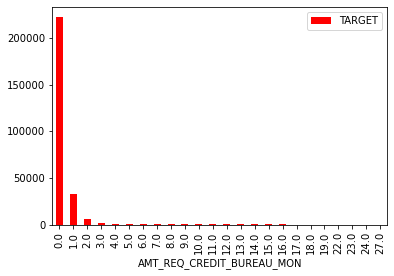

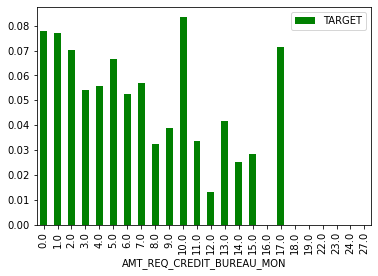

In [11]:
def groupby_plot(column):
    group_count = appl_data[[column,'TARGET']].groupby(column, as_index = False).count()
    target_rate = appl_data[[column,'TARGET']].groupby(column, as_index = False).mean() 
    
    print("Distribution(Red) & Target Rate(Green):")
    group_count.plot(kind='bar', x = column, color='r')
    target_rate.plot(kind='bar', x = column, color='g')
    
    return

groupby_plot('AMT_REQ_CREDIT_BUREAU_MON')

The figures above shows that, these features are very limited in the amount of non-zero records and therefore could show little significance in their correlations with the target.
So these features would also be dropped.

In [12]:
appl_data = appl_data.drop(labels = [
    'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'
], axis = 1)
# appl_data

In [13]:
# null_rate_appl() #.info()

### Document Flags

We notice there existing a series of 'FLAG_DOCUMENT', which represent the status of submission of certain types of documents.
Since they are all dummy variables, we add them up to see their ratios of presence.

In [14]:
flag_doc_list = [
    'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
]

appl_data[flag_doc_list].sum()/len(appl_data)

FLAG_DOCUMENT_2     0.000042
FLAG_DOCUMENT_3     0.710023
FLAG_DOCUMENT_4     0.000081
FLAG_DOCUMENT_5     0.015115
FLAG_DOCUMENT_6     0.088055
FLAG_DOCUMENT_7     0.000192
FLAG_DOCUMENT_8     0.081376
FLAG_DOCUMENT_9     0.003896
FLAG_DOCUMENT_10    0.000023
FLAG_DOCUMENT_11    0.003912
FLAG_DOCUMENT_12    0.000007
FLAG_DOCUMENT_13    0.003525
FLAG_DOCUMENT_14    0.002936
FLAG_DOCUMENT_15    0.001210
FLAG_DOCUMENT_16    0.009928
FLAG_DOCUMENT_17    0.000267
FLAG_DOCUMENT_18    0.008130
FLAG_DOCUMENT_19    0.000595
FLAG_DOCUMENT_20    0.000507
FLAG_DOCUMENT_21    0.000335
dtype: float64

Among the Flag Documents (i.e., 'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3',...), only 'FLAG_DOCUMENT_3' gives a considerable rate of presence that might help in further work, so the rest of them would be dropped.

In [15]:
flag_doc_list.remove("FLAG_DOCUMENT_3")
appl_data = appl_data.drop(labels = flag_doc_list,axis = 1)
# appl_data

In [16]:
# null_rate_appl() # Use this to check remaining features

### Suite Type

Distribution(Red) & Target Rate(Green):


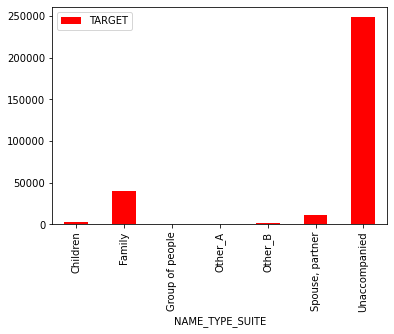

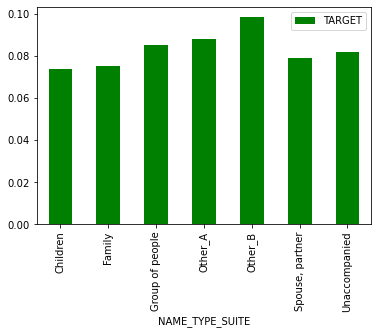

In [17]:
groupby_plot('NAME_TYPE_SUITE')

With a relatively small null rate (0.42%), the nulls in this feature would be replaced with "Unaccompanied", which is the most commonly observed value.

In [18]:
appl_data = appl_data.fillna(value = {'NAME_TYPE_SUITE':'Unaccompanied'})
# appl_data

### Social Circle

These features recorded the amount of defaults among social surroundings of the client during certain time periods.
We decide whether to drop them according to their correlations with the target.

In [19]:
soc_cir_corr = appl_data[[
    'TARGET',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'
]].corr()

# soc_cir_corr

The matrix implies that these features should be dropped.

In [20]:
appl_data = appl_data.drop(labels = [
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'
] ,axis = 1)
# appl_data

In [21]:
null_rate_appl()

,Features,Null Rate
10,AMT_GOODS_PRICE,0.090403
9,AMT_ANNUITY,0.003902
28,CNT_FAM_MEMBERS,0.000650
40,DAYS_LAST_PHONE_CHANGE,0.000325
0,SK_ID_CURR,0.000000
31,WEEKDAY_APPR_PROCESS_START,0.000000
24,FLAG_CONT_MOBILE,0.000000
25,FLAG_PHONE,0.000000
26,FLAG_EMAIL,0.000000
27,OCCUPATION_TYPE,0.000000


### Remaining Nulls

4 features remained with nulls to deal with:

CNT_FAM_MEMBERS, AMT_ANNUITY, AMT_GOODS_PRICE, DAYS_LAST_PHONE_CHANGE.

For CNT_FAM_MEMBERS, we take the median to replace nulls, and we take the means for the other 3.

In [22]:
appl_data = appl_data.fillna(value = {
    'CNT_FAM_MEMBERS':appl_data['CNT_FAM_MEMBERS'].median(),
    'AMT_ANNUITY':appl_data['AMT_ANNUITY'].mean(),
    'AMT_GOODS_PRICE':appl_data['AMT_GOODS_PRICE'].mean(),
    'DAYS_LAST_PHONE_CHANGE':appl_data['DAYS_LAST_PHONE_CHANGE'].mean()
})

In [23]:
appl_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,-1134.0,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,-828.0,1
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,-815.0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,-617.0,1
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,-1106.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,-273.0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,XNA,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.0,1
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,-1909.0,1
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1,-322.0,1


## Unrealistic Values & Standardization

For the numeric features, see if there exist unrealistic value records:

In [24]:
appl_data_num = appl_data.select_dtypes(exclude = 'object')
#appl_data_num.max()
appl_data_num.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152664,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,-962.858788,0.710023
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910679,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,826.807143,0.453752
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-757.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-274.000000,1.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


CNTs need to simplify by rank;

AMTs need to take log;

DAYS_EMPLOYED contains unrealistic values;

FLAG_MOBIL has a mean very close to 1, delete this feature;

FLAG_CONT_MOBILE as well;

HOUR_APPR_PROCESS_START check distribution and corr to decide whether to drop;

In [25]:
appl_data.loc[appl_data['CNT_CHILDREN'] > 4, 'CNT_CHILDREN'] = 4

Distribution(Red) & Target Rate(Green):


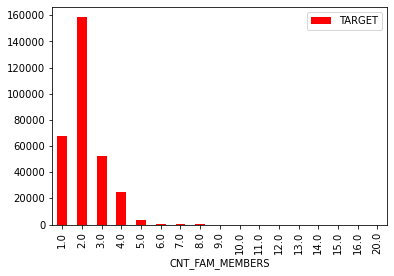

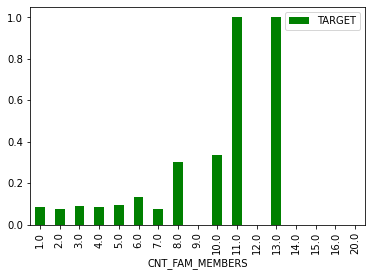

In [26]:
groupby_plot('CNT_FAM_MEMBERS')
appl_data.loc[appl_data['CNT_FAM_MEMBERS'] > 5, 'CNT_FAM_MEMBERS'] = 5

In [27]:
appl_data[[
    'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'
]] = np.log(appl_data[[
    'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'
]])

In [28]:
appl_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.416206,11.909238,13.070105,10.067630,12.960698,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.150138,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,-962.858788,0.710023
std,102790.175348,0.272419,0.714936,0.488910,0.715196,0.545902,0.715232,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.898706,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,826.807143,0.453752
min,100002.000000,0.000000,0.000000,10.152299,10.714418,7.387400,10.609057,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000
25%,189145.500000,0.000000,0.000000,11.630709,12.506177,9.712569,12.382125,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000
50%,278202.000000,0.000000,0.000000,11.899208,13.149066,10.122744,13.017003,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-757.000000,1.000000
75%,367142.500000,0.000000,1.000000,12.218495,13.603121,10.451493,13.429113,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-274.000000,1.000000
max,456255.000000,1.000000,4.000000,18.577684,15.214227,12.460814,15.214227,0.072508,-7489.000000,365243.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


In [29]:
appl_data[appl_data['DAYS_EMPLOYED'] > 0][['NAME_INCOME_TYPE','TARGET']].groupby('NAME_INCOME_TYPE', as_index = False).mean()

,NAME_INCOME_TYPE,TARGET
0,Pensioner,0.053873
1,Unemployed,0.363636


By checking the income type of those who have positive values in 'DAYS_EMPLOYED', we found they are either pensioner or unemployed. Therefore we set those values to 0.

In [30]:
appl_data.loc[appl_data['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
appl_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.416206,11.909238,13.070105,10.067630,12.960698,0.020868,-16036.995067,-1954.848123,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.150138,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,-962.858788,0.710023
std,102790.175348,0.272419,0.714936,0.488910,0.715196,0.545902,0.715232,0.013831,4363.988632,2307.068896,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.898706,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,826.807143,0.453752
min,100002.000000,0.000000,0.000000,10.152299,10.714418,7.387400,10.609057,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000
25%,189145.500000,0.000000,0.000000,11.630709,12.506177,9.712569,12.382125,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000
50%,278202.000000,0.000000,0.000000,11.899208,13.149066,10.122744,13.017003,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-757.000000,1.000000
75%,367142.500000,0.000000,1.000000,12.218495,13.603121,10.451493,13.429113,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-274.000000,1.000000
max,456255.000000,1.000000,4.000000,18.577684,15.214227,12.460814,15.214227,0.072508,-7489.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


In [31]:
appl_data = appl_data.drop(columns = ['FLAG_MOBIL','FLAG_CONT_MOBILE'])

## One-Hot Encoding

In [32]:
appl_data.set_index(['SK_ID_CURR'], inplace = True)

appl_data['CNT_FAM_MEMBERS'] = appl_data['CNT_FAM_MEMBERS'].astype(int)

order = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 
       'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN',
       'CNT_FAM_MEMBERS', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'FLAG_DOCUMENT_3']

appl_data = appl_data[order]
appl_data.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,CNT_FAM_MEMBERS,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,12.218495,12.915579,10.114579,12.768542,0.018801,-9461,-637,-3648.0,-2120,-1134.0,Cash loans,M,N,Y,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,1,0,Laborers,2,2,WEDNESDAY,0,0,0,0,0,0,Business Entity Type 3,1
100003,0,12.506177,14.072864,10.482864,13.937286,0.003541,-16765,-1188,-1186.0,-291,-828.0,Cash loans,F,N,N,0,2,Family,State servant,Higher education,Married,House / apartment,1,0,1,0,Core staff,1,1,MONDAY,0,0,0,0,0,0,School,1
100004,0,11.119883,11.813030,8.817298,11.813030,0.010032,-19046,-225,-4260.0,-2531,-815.0,Revolving loans,M,Y,Y,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,1,0,Laborers,2,2,MONDAY,0,0,0,0,0,0,Government,0
100006,0,11.813030,12.652944,10.298448,12.601487,0.008019,-19005,-3039,-9833.0,-2437,-617.0,Cash loans,F,N,Y,0,2,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,0,Laborers,2,2,WEDNESDAY,0,0,0,0,0,0,Business Entity Type 3,1
100007,0,11.707670,13.148031,9.992665,13.148031,0.028663,-19932,-3038,-4311.0,-3458,-1106.0,Cash loans,M,N,Y,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Core staff,2,2,THURSDAY,0,0,0,0,1,1,Religion,0


In [33]:
appl_data_dum = pd.get_dummies(appl_data)
appl_data_dum.dtypes

TARGET                                                 int64
AMT_INCOME_TOTAL                                     float64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
AMT_GOODS_PRICE                                      float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                             int64
DAYS_EMPLOYED                                          int64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                        int64
DAYS_LAST_PHONE_CHANGE                               float64
CNT_CHILDREN                                           int64
CNT_FAM_MEMBERS                                        int64
FLAG_EMP_PHONE                                         int64
FLAG_WORK_PHONE                                        int64
FLAG_PHONE                                             int64
FLAG_EMAIL              

In [34]:
appl_data_dum_bool = appl_data_dum
appl_data_dum_bool.loc[:,'FLAG_EMP_PHONE':] = appl_data_dum_bool.loc[:,'FLAG_EMP_PHONE':].astype(bool)
appl_data_dum_bool

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,CNT_FAM_MEMBERS,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZA

## Scaling

In [35]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

In [36]:
train_set, test_set = train_test_split(appl_data_dum_bool, test_size = 0.2, random_state = 123)
y_train = pd.DataFrame(train_set['TARGET'])
train_num = train_set.loc[:,'AMT_INCOME_TOTAL':'CNT_FAM_MEMBERS']
train_obj = train_set.loc[:,'FLAG_EMP_PHONE':]

y_test = pd.DataFrame(test_set['TARGET'])
test_num = test_set.loc[:,'AMT_INCOME_TOTAL':'CNT_FAM_MEMBERS']
test_obj = test_set.loc[:,'FLAG_EMP_PHONE':]

In [37]:
train_num_tr = pd.DataFrame(StandardScaler().fit_transform(train_num), index = train_num.index, columns = train_num.columns)
test_num_tr = pd.DataFrame(StandardScaler().fit_transform(test_num), index = test_num.index, columns = test_num.columns)

In [38]:
train_tr = pd.merge(train_num_tr, train_obj, left_index = True, right_index = True)
test_tr = pd.merge(test_num_tr, test_obj, left_index = True, right_index = True)

In [39]:
train_tr.dtypes

AMT_INCOME_TOTAL                                     float64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
AMT_GOODS_PRICE                                      float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                           float64
DAYS_EMPLOYED                                        float64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                      float64
DAYS_LAST_PHONE_CHANGE                               float64
CNT_CHILDREN                                         float64
CNT_FAM_MEMBERS                                      float64
FLAG_EMP_PHONE                                          bool
FLAG_WORK_PHONE                                         bool
FLAG_PHONE                                              bool
FLAG_EMAIL                                              bool
REGION_RATING_CLIENT    

## Over-Sampling

In [40]:
smo = SMOTE(sampling_strategy = 1, random_state = 123)
tr_smo, y_smo = smo.fit_resample(train_tr, y_train)

In [41]:
df_smo = pd.merge(y_smo, tr_smo, left_index=True, right_index=True)

The Scaled Sets: train_tr, y_train

The Over-Sampled Sets: tr_smo, y_smo

### Information Value (IV)

In [42]:
def calculate_woe_iv(dataset, feature, target = 'TARGET'):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return iv

The following codes calculates the IV of the dummy variables.

In [43]:
df_iv = pd.DataFrame()

for col in train_obj.columns:
    df_iv.loc[col,0] = calculate_woe_iv(df_smo, col)

df_iv

,0
FLAG_EMP_PHONE,3.378146e-02
FLAG_WORK_PHONE,6.108638e-02
FLAG_PHONE,3.845209e-03
FLAG_EMAIL,3.224079e-03
REGION_RATING_CLIENT,0.000000e+00
REGION_RATING_CLIENT_W_CITY,0.000000e+00
REG_REGION_NOT_LIVE_REGION,8.935746e-04
REG_REGION_NOT_WORK_REGION,2.114910e-03
LIVE_REGION_NOT_WORK_REGION,1.224459e-03
REG_CITY_NOT_LIVE_CITY,4.960632e-02


We will Drop the columns with IV lower than 0.1 !!!

## Correlation Heatmap

In [44]:
df_iv_d = df_iv[df_iv[0] < 0.1]
dropper = df_iv_d.transpose().columns
tr_iv = tr_smo.drop(columns = dropper)
tst_iv = test_tr.drop(columns = dropper)

In [45]:
tr_corr = tr_iv.corr()

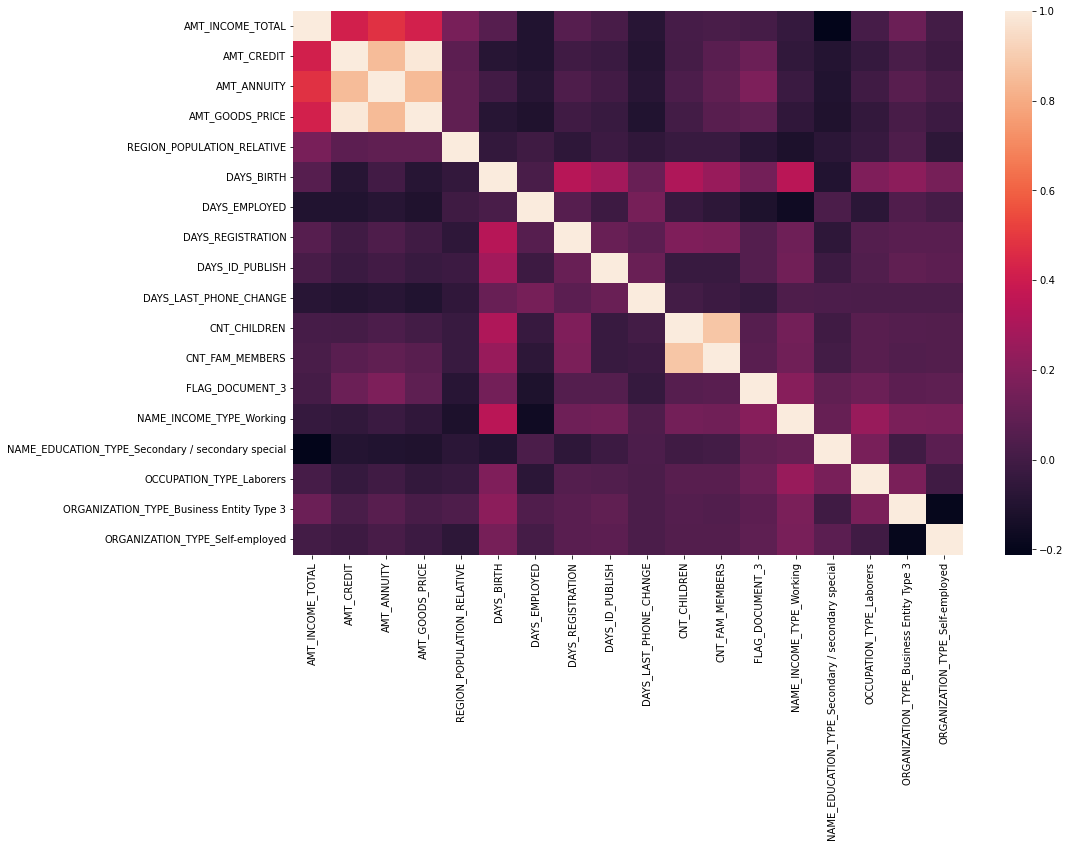

In [46]:
plt.figure(figsize = (15,10))
sns.heatmap(tr_corr)
plt.show()

## PCA

In [47]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(tr_iv)
pca_var_ratio = pca.explained_variance_ratio_.astype(float)
pca_var_ratio

array([0.22976713, 0.18192654, 0.11145576, 0.07735203, 0.07067251,
       0.06715011, 0.05678753, 0.05010765, 0.04603925, 0.02179114,
       0.01766973, 0.0144563 , 0.0130491 , 0.01126966, 0.01080803,
       0.00970308, 0.00912924, 0.0008652 ])

In [48]:
pca_var_ratio

summ = 0
counter = 0
for i in range(0,len(pca_var_ratio)):
    summ = summ + pca_var_ratio[i]
    counter = counter + 1
    if (summ > 0.9):
        break
counter

10

In [49]:
pca = PCA(n_components = 10)
pca.fit(tr_iv)

PCA(n_components=10)

In [50]:
tr_pca = pd.DataFrame(pca.transform(tr_iv))
test_pca = pd.DataFrame(pca.transform(tst_iv))
test_pca

,0,1,2,3,4,5,6,7,8,9
0,2.111832,-0.394174,-0.336719,-0.755399,-0.412660,-0.802290,1.099437,-0.655133,-0.807518,-0.051279
1,-2.484605,-0.749994,0.750727,-0.967665,-0.022427,0.818174,0.036820,0.232773,-0.937027,-0.440114
2,-3.712806,0.222854,-1.097743,1.149449,-0.767129,0.573013,0.002522,-0.453922,0.997103,0.563888
3,1.248139,-1.447773,0.912672,-0.494545,0.626050,-0.613765,0.988944,0.741278,1.816225,0.271733
4,-1.389733,0.179256,-0.912722,1.435113,-0.212453,-1.005980,-2.002065,-0.822128,0.162142,-0.475946
...,...,...,...,...,...,...,...,...,...,...
61498,2.924807,-1.628837,1.174225,-0.045202,-0.957710,-0.179868,0.216545,0.183005,0.140245,-0.340302
61499,-4.430939,-1.733772,2.498230,-0.587929,1.274262,1.505127,0.115451,0.060400,0.106008,0.212224
61500,1.918957,-1.746777,1.243590,0.290523,-0.515495,1.166939,-0.861514,0.249750,-0.806948,0.194087
61501,-1.553112,0.507725,1.139303,0.377573,-0.560682,-1.012301,-1.202271,0.941189,-0.662854,-0.331591


## Logit Regression

### Stepwise

Stepwise not easy to apply in Python, so export the data to R. 

In [51]:
tr_iv.to_csv(path_or_buf = "/Users/jackyh/Desktop/MFIT5001_AI/Proj/archive/tr_iv.csv" )
tr_pca.to_csv(path_or_buf = "/Users/jackyh/Desktop/MFIT5001_AI/Proj/archive/tr_pca.csv" )
y_smo.to_csv(path_or_buf = "/Users/jackyh/Desktop/MFIT5001_AI/Proj/archive/y_smo.csv" )

The Stepwise of Logit Models start from:

 for tr_iv:

and,

 for tr_pca:

The result of stepwise selection (by AIC) showed that no input should be removed, for both models before and after PCA.

    y_smo ~ x0 + x1 + x2 + x3 + x4 + x5 + x7 + x8 + x9 + 
    x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 +     
    x20 + x21 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30

In [52]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(tr_iv, y_smo)


/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [53]:
y_pred_log = log_reg.predict(tst_iv)

In [54]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [55]:
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[38034 18454]
 [ 2401  2614]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     56488
           1       0.12      0.52      0.20      5015

    accuracy                           0.66     61503
   macro avg       0.53      0.60      0.49     61503
weighted avg       0.87      0.66      0.74     61503



In [56]:
log_reg_pca = LogisticRegression()
log_reg_pca.fit(tr_pca, y_smo)


/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [57]:
y_pred_log_pca = log_reg_pca.predict(test_pca)

In [58]:
print(confusion_matrix(y_test, y_pred_log_pca))
print(classification_report(y_test, y_pred_log_pca))

[[37683 18805]
 [ 2427  2588]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     56488
           1       0.12      0.52      0.20      5015

    accuracy                           0.65     61503
   macro avg       0.53      0.59      0.49     61503
weighted avg       0.87      0.65      0.73     61503



The Odds Ratios calculated in R:

                                        (Intercept)                                    AMT_INCOME_TOTAL 
                                          0.1127362                                           0.9612345 
                                         AMT_CREDIT                                         AMT_ANNUITY 
                                          3.8166405                                           1.0217168 
                                    AMT_GOODS_PRICE                          REGION_POPULATION_RELATIVE 
                                          0.2671937                                           0.9117958 
                                         DAYS_BIRTH                                       DAYS_EMPLOYED 
                                          1.0728762                                           1.3796538 
                                  DAYS_REGISTRATION                                     DAYS_ID_PUBLISH 
                                          1.1079055                                           1.0677043 
                             DAYS_LAST_PHONE_CHANGE                                        CNT_CHILDREN 
                                          1.2204443                                           0.9687285 
                                    CNT_FAM_MEMBERS                                 FLAG_DOCUMENT_3True 
                                          0.9499648                                           2.0412151 
                       NAME_INCOME_TYPE_WorkingTrue NAME_EDUCATION_TYPE_Secondary_secondary_specialTrue 
                                          1.4817494                                           2.6612135 
                       OCCUPATION_TYPE_LaborersTrue        ORGANIZATION_TYPE_Business_Entity_Type_3True 
                                          1.6335335                                           2.1184484 
                ORGANIZATION_TYPE_Self_employedTrue
                                          2.2728718

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def roc_draw(y1,y2):
    fpr, tpr, thersholds = roc_curve(y_test, y1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    fpr, tpr, thersholds = roc_curve(y_test, y2)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve PCA')
    plt.legend(loc="lower right")
    plt.show()
    
    return


Logit


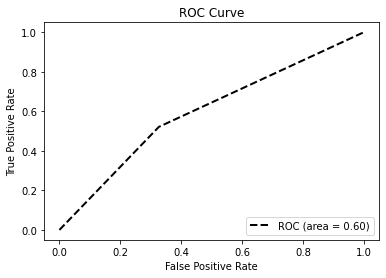

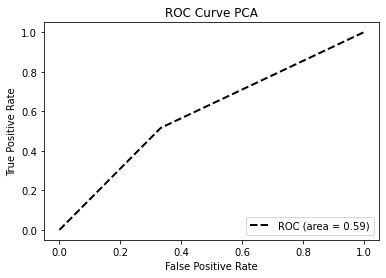

In [60]:
print('Logit')
roc_draw(y_pred_log,y_pred_log_pca)

## Linear SVM

In [61]:
from sklearn.svm import LinearSVC

In [62]:
linear_svc = LinearSVC(C=1, loss = 'hinge')
linear_svc.fit(tr_iv,y_smo)

/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1, loss='hinge')

In [63]:
y_pred_lsvc = linear_svc.predict(tst_iv)

In [64]:
print(confusion_matrix(y_test, y_pred_lsvc))
print(classification_report(y_test, y_pred_lsvc))

[[38401 18087]
 [ 2421  2594]]
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     56488
           1       0.13      0.52      0.20      5015

    accuracy                           0.67     61503
   macro avg       0.53      0.60      0.50     61503
weighted avg       0.87      0.67      0.74     61503



In [65]:
linear_svc = LinearSVC(C=1, loss = 'hinge')
linear_svc.fit(tr_pca,y_smo)

/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1, loss='hinge')

In [66]:
y_pred_lsvc_pca = linear_svc.predict(test_pca)

In [67]:
print(confusion_matrix(y_test, y_pred_lsvc_pca))
print(classification_report(y_test, y_pred_lsvc_pca))

[[37752 18736]
 [ 2438  2577]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     56488
           1       0.12      0.51      0.20      5015

    accuracy                           0.66     61503
   macro avg       0.53      0.59      0.49     61503
weighted avg       0.87      0.66      0.73     61503



Linear SVC


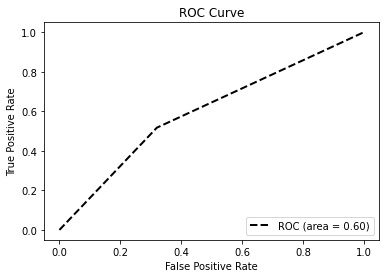

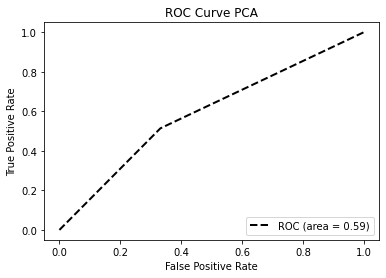

In [68]:
print('Linear SVC')
roc_draw(y_pred_lsvc,y_pred_lsvc_pca)

## Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(tr_iv,y_smo)

DecisionTreeClassifier(max_depth=2)

In [71]:
y_pred_tree = tree_clf.predict(tst_iv)

In [72]:
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[35368 21120]
 [ 2526  2489]]
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     56488
           1       0.11      0.50      0.17      5015

    accuracy                           0.62     61503
   macro avg       0.52      0.56      0.46     61503
weighted avg       0.87      0.62      0.70     61503



In [73]:
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(tr_pca,y_smo)

DecisionTreeClassifier(max_depth=2)

In [74]:
y_pred_tree_pca = tree_clf.predict(test_pca)

In [75]:
print(confusion_matrix(y_test, y_pred_tree_pca))
print(classification_report(y_test, y_pred_tree_pca))

[[43987 12501]
 [ 3581  1434]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     56488
           1       0.10      0.29      0.15      5015

    accuracy                           0.74     61503
   macro avg       0.51      0.53      0.50     61503
weighted avg       0.86      0.74      0.79     61503



Decision Tree


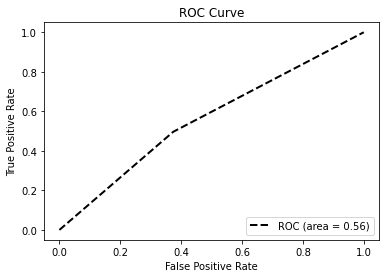

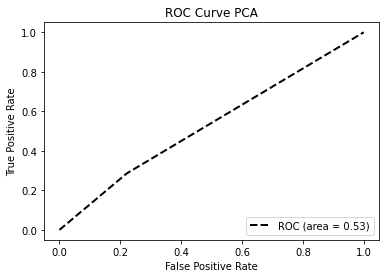

In [76]:
print('Decision Tree')
roc_draw(y_pred_tree,y_pred_tree_pca)

## Random Forest

In [77]:
from sklearn.ensemble import BaggingClassifier

In [78]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 10000, bootstrap = True, n_jobs = -1)
bag_clf.fit(tr_iv,y_smo)

/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=10000,
                  n_estimators=500, n_jobs=-1)

In [79]:
y_pred_bag = bag_clf.predict(tst_iv)

In [80]:
print(confusion_matrix(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))

[[41651 14837]
 [ 2874  2141]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.82     56488
           1       0.13      0.43      0.19      5015

    accuracy                           0.71     61503
   macro avg       0.53      0.58      0.51     61503
weighted avg       0.87      0.71      0.77     61503



In [81]:
import lime
import lime.lime_tabular

In [82]:
predict_fn_rf = lambda x: bag_clf.predict_proba(x).astype(float)
X = tr_iv.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names = tr_iv.columns,
                                                   class_names=['Wont Default','Will Default'],
                                                   kernel_width=5)
choosen_instance = tst_iv.loc[[431774]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)



In [83]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 10000, bootstrap = True, n_jobs = -1)
bag_clf.fit(tr_pca,y_smo)

/Users/jackyh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=10000,
                  n_estimators=500, n_jobs=-1)

In [84]:
y_pred_bag_pca = bag_clf.predict(test_pca)

In [85]:
print(confusion_matrix(y_test, y_pred_bag_pca))
print(classification_report(y_test, y_pred_bag_pca))

[[41230 15258]
 [ 2721  2294]]
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     56488
           1       0.13      0.46      0.20      5015

    accuracy                           0.71     61503
   macro avg       0.53      0.59      0.51     61503
weighted avg       0.87      0.71      0.77     61503



Random Forest


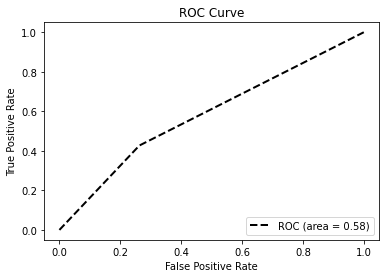

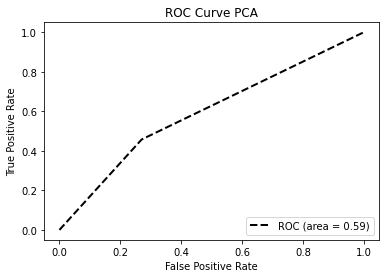

In [86]:
print('Random Forest')
roc_draw(y_pred_bag,y_pred_bag_pca)

In [87]:
predict_fn_rf = lambda x: bag_clf.predict_proba(x).astype(float)
X = tr_pca.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names = tr_pca.columns,
                                                   class_names=['Wont Default','Will Default'],
                                                   kernel_width=5)
choosen_instance = test_pca.loc[[42]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

